# Image Analysis of Touching Circles

This is a simple particle analysis of touching circles from an image by John Russ. The analysis was adapted from a [pythonvision](http://pythonvision.org/basic-tutorial) tutorial and converted to work with python 3.51 (Anaconda 2.41) and and to mainly use skimage.
  
The image came from [Reindeer Graphics](http://www.reindeergraphics.com/tutorial/image-447.png.png).

Note that since the skimage regionprops supplies the bounding box, we can just eliminate the features touching the borders.

## First, import the packages we need

I like to put this all up front and include any notebook magic that is helpful.

In [1]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as nd
import warnings

import skimage.exposure as expo
import skimage.feature as fea       # peak_local_max
import skimage.filters as fil       # rank, moved from .filter
import skimage.io as io
import skimage.measure as mea       # regionprops
import skimage.morphology as mor    # watershed, disk

## Define functions to plot our images and gray level histograms

In [2]:
def plotOneImage(dat, label, sFont=12, size=(10,10), colormap=plt.cm.gray):
    """plotOneImage(dat, label, sizeFont=12, size=(10,10), colormap=plt.cm.gray)
    Use matplotlib to plot the image
    Input:
    dat      - a numpy array with the data
    label    - a title
    sFont    - the size of the font, default 12
    size     - a tuple, default (10,10) with the figure size
    colormap - a pyplot color map, default plt.cm.gray
    Return:
    a matplotlib figure"""
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=size)
    ax0 = axes 
    ax0.imshow(dat, cmap=colormap, interpolation='nearest')
    ax0.set_title(label, fontsize=sFont)
    ax0.axis('off')
    fig.show()
    return(fig)

def plotGrayLevelHistogram(im, label, sFont=12, size=(10,10), bins=256):
    """Use matplotlib to plot the gray level histogram of an image"""
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=size)
    ax0 = axes
    his = im.flatten()
    plt.hist(his, bins)
    plt.show()
    ax0.set_xlabel('gray level', fontsize=sFont)
    ax0.set_ylabel('count', fontsize=sFont)
    sTitle = label + ' - gray level histogram'
    ax0.set_title(sTitle, fontsize=sizeFont)
    fig.show()
    return(fig)

## Define some file names and read in our image

In [3]:
warnings.filterwarnings('ignore')
fOut = 'features.csv'
fImg = './circles.png'
sizeFont = 12

im = io.imread(fImg)
print(im.dtype)
print(im.shape)
imgRows = im.shape[0]
imgCols = im.shape[1]

uint8
(252, 252)


## Examine the input image

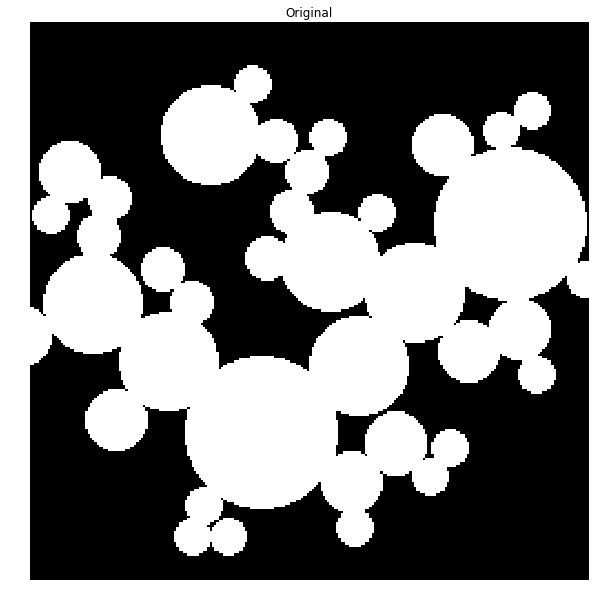

In [4]:
figOri = plotOneImage(im, "Original", sFont=sizeFont, colormap=plt.cm.gray)
figOri.show()

## Compute and display the histogram

This will not be surprisng for binary image...

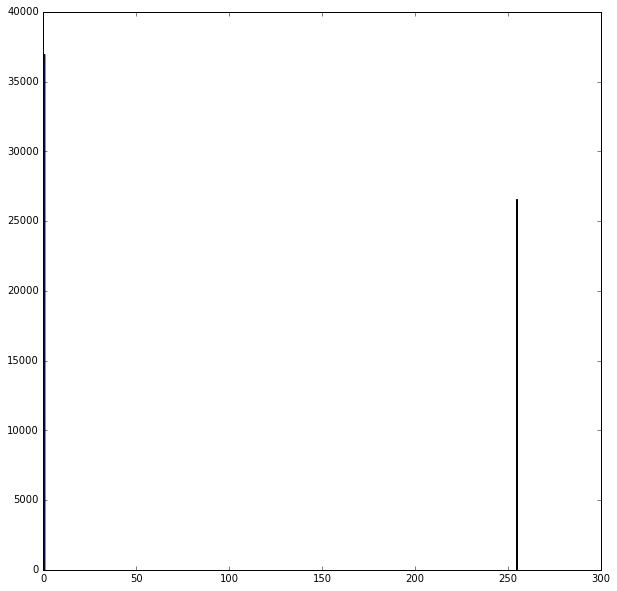

In [5]:
diaHistFig = plotGrayLevelHistogram(im, "Original", sFont=12, bins=256)
diaHistFig.show()

## Set a gray level threshold

In [6]:
thr = im > 0.5

## Compute the Euclidean Distance Transform

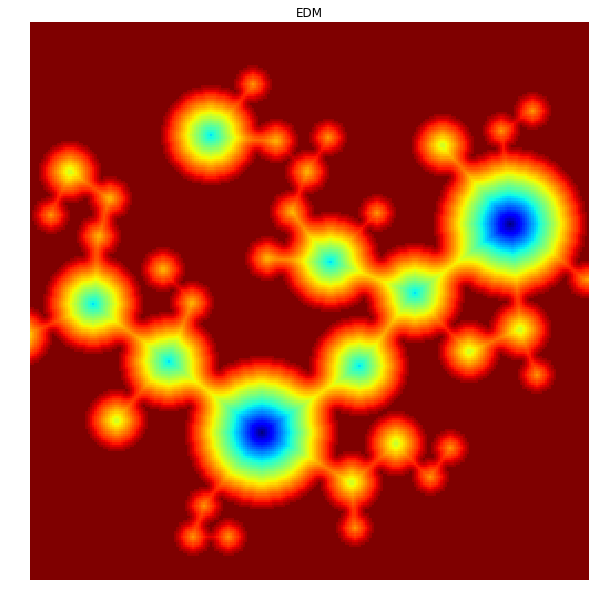

In [7]:
dis = nd.distance_transform_edt(thr).astype(np.float32)
disFig = plotOneImage(-dis, "EDM", sFont=12, colormap=plt.cm.jet)
disFig.show()

## Smooth the Euclidean Distance Transform

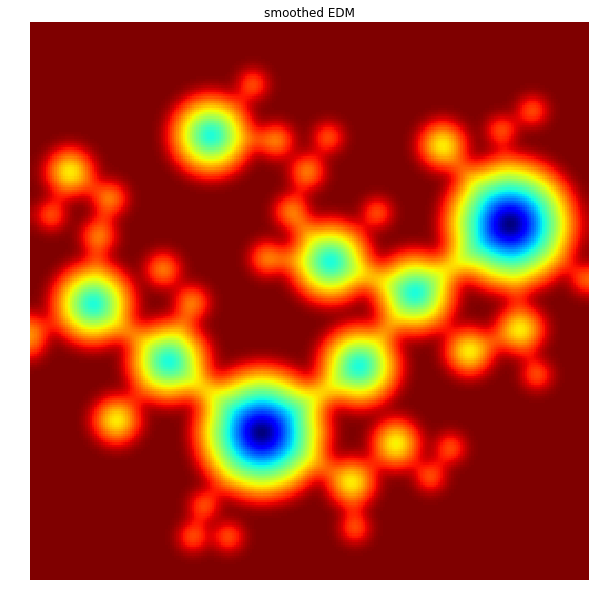

In [8]:
blur = nd.gaussian_filter(dis,3)
blurFig = plotOneImage(-blur, "smoothed EDM", sFont=12, colormap=plt.cm.jet)
blurFig.show()

## Find the local maxima and do a Watershed separation

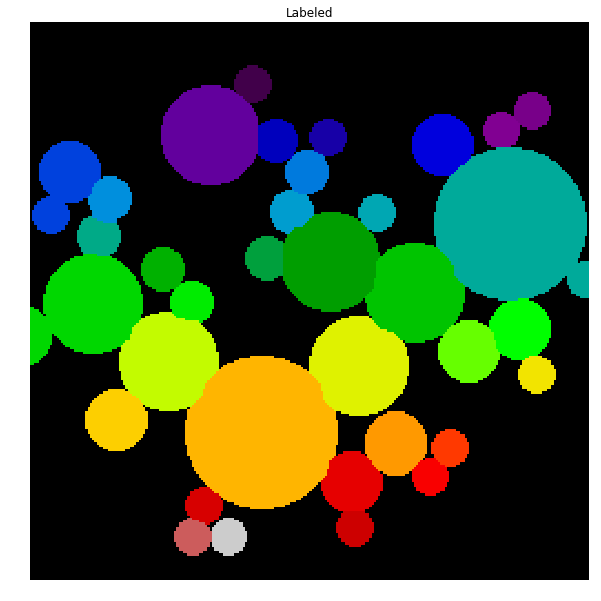

In [9]:
lMax = fea.peak_local_max(blur, indices=False, footprint=np.ones((3, 3)), labels=im)
mrk = nd.label(lMax)[0]
lab = mor.watershed(-dis, mrk, mask=thr)
labFig = plotOneImage(lab, "Labeled", sFont=12, colormap=plt.cm.spectral)
labFig.show()


## Compute the properties

In [10]:
props = mea.regionprops(lab, cache=True)
l = len(props)

## Write out the diameters

In [11]:
f = open(fOut,'w')
line = "label, ecd, minor.ax.len, major.ax.len, ar, solidity"
print(line)
f.write(line+'\n')
for i in range(l):
    # check the labeled regions for border touching
    theBox = props[i].bbox
    if(theBox[0] > 0):
        if(theBox[1] > 0):
            if(theBox[2] < imgRows):
                if(theBox[3] < imgCols):
                    ecd = 2.0 * math.sqrt(props[i].area/math.pi)
                    ar = props[i].major_axis_length / props[i].minor_axis_length
                    line = "%g, %g," % (i+1, ecd)
                    line += "%g," % props[i].minor_axis_length
                    line += "%g," % props[i].major_axis_length
                    line += "%g, %g" % (ar, props[i].solidity)
                    print(line)
                    f.write(line+'\n')
f.close()

label, ecd, minor.ax.len, major.ax.len, ar, solidity
1, 16.8125,16.6139,17.0332,1.02523, 0.961039
2, 16.9257,16.8622,16.9883,1.00748, 0.965665
3, 16.7366,16.3471,17.1547,1.0494, 0.986547
4, 44.9373,44.7138,45.1699,1.0102, 0.988778
5, 16.9257,16.9244,16.9244,1, 0.965665
6, 19.5441,18.7784,20.4522,1.08913, 0.980392
7, 27.8003,27.456,28.1852,1.02656, 0.983793
8, 32.4495,25.1815,45.7574,1.81711, 0.894054
9, 20.0585,19.8194,20.2924,1.02386, 0.981366
10, 20.2166,19.1939,21.3642,1.11308, 0.955357
11, 19.1492,18.1811,20.3699,1.12039, 0.96
12, 16.888,16.8092,16.9621,1.0091, 0.965517
14, 18.8138,17.1206,20.9961,1.22636, 0.952055
15, 19.0826,17.823,20.6408,1.1581, 0.979452
16, 44.4959,43.795,45.296,1.03427, 0.980454
17, 20.0902,20.0227,20.1511,1.00641, 0.972393
18, 43.8474,42.868,45.167,1.05363, 0.966091
20, 19.3805,18.564,20.3528,1.09636, 0.970395
21, 27.5703,27.422,27.7985,1.01373, 0.970732
22, 27.7315,27.2704,28.2511,1.03596, 0.980519
23, 44.1512,43.7414,44.7699,1.02351, 0.970215
24, 44.3383,4

## Plot the three key images

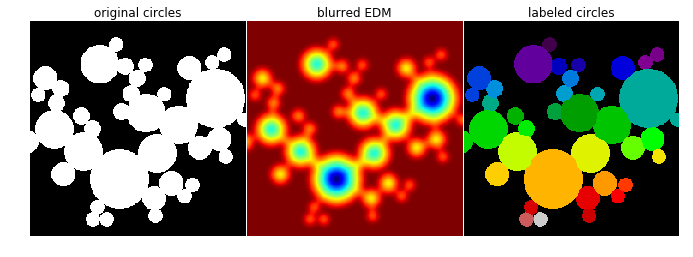

In [12]:
fig, axes = plt.subplots(ncols=3, figsize=(9, 3))
ax0, ax1, ax2 = axes
ax0.imshow(im, cmap=plt.cm.gray, interpolation='nearest')
ax0.set_title('original circles')
ax1.imshow(-blur, cmap=plt.cm.jet, interpolation='nearest')
ax1.set_title('blurred EDM')
ax2.imshow(lab, cmap=plt.cm.spectral, interpolation='nearest')
ax2.set_title('labeled circles')
for ax in axes:
  ax.axis('off')
plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)
plt.show()

In [13]:
%reload_ext load_style
%load_style ../themes/tutorial.css